In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install kiwipiepy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
pip install konlpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import numpy as np
import pandas as pd

C:\Users\cmhcm\AppData\Local\Temp\ipykernel_13960\1662815981.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 14781개 뉴스 데이터 가져오기
- 풀본문 있는 데이터 입니다.

In [6]:
data_path = "C:/dev/openAI/result_df_14761.csv"
df = pd.read_csv(data_path, dtype=str)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14761 entries, 0 to 14760
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   news_id       14761 non-null  object
 1   news_date     14761 non-null  object
 2   news_keyword  14761 non-null  object
 3   news_feature  14761 non-null  object
 4   news_url      14686 non-null  object
 5   news_content  14761 non-null  object
 6   img_url       13992 non-null  object
dtypes: object(7)
memory usage: 807.4+ KB


# 중복제거 로직
- 형태소 분석기: Okt
- 벡터화: CountVectorizer
- 중복 기준: news_content 컬럼 데이터

In [7]:
from konlpy.tag import Okt

# 형태소 분석기 초기화
okt = Okt()

In [8]:
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer

# 전처리 함수 정의
def tokenizer(raw, pos=["Noun", "Alpha", "Number"], stopword=[]):
    return [
        word for word, tag in okt.pos(
            raw,
            norm=True,
            stem=True
            )
            if len(word) > 1 and tag in pos and word not in stopword
        ]

## 전처리 및 벡터화

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

vectorize = CountVectorizer(
    tokenizer=tokenizer,
    min_df=2
)

In [10]:
# 기사 본문에 나오는 단어의 빈도 계산
X = vectorize.fit_transform(df['news_content'])

c:\Users\cmhcm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [11]:
from sklearn.metrics.pairwise import cosine_similarity

# 코사인 유사도 계산
cos_sim = cosine_similarity(X)

# 코사인 유사도가 0.9 이상인 경우를 중복으로 판단
dup_idx = np.where(cos_sim > 0.9)

In [12]:
# 중복 기사 인덱스와 제목 출력 및 중복 기사 제거
to_drop = []

for i in range(len(dup_idx[0])):
    if dup_idx[0][i] != dup_idx[1][i]:  # 자기 자신과의 유사도는 제외

        # 먼저 게시된 기사를 남기고 싶으므로 인덱스가 더 작은 행을 제거
        to_remove = min(dup_idx[0][i], dup_idx[1][i])
        # print("삭제되는 기사 제목: ", df.iloc[to_remove]['news_id'])
        # print()

        to_drop.append(to_remove)

# 중복 기사 제거
df = df.drop(to_drop)
# 인덱스 재설정
df = df.reset_index(drop=True)

### 4,353개의 중복기사 제거

In [13]:
# 중복제거 확인
df.shape

(10429, 7)

# 전처리

### news_url: null일 경우 삭제

In [14]:
# url컬럼이 null 값을 가진 행 삭제
# df = df.dropna(subset=['news_url'])

### news_content: 명사/알파벳/숫자 추출
- tokenizer 함수는 중복제거 단계에서 정의함
- news_content 컬럼은 OpneAI에서 사용하기 때문에 삭제하면 안됨

In [15]:
preprocessed_text = df['news_content'].apply(lambda x: ' '.join(tokenizer(x)))
df['summery_content'] = preprocessed_text

### 불용어 정의 및 제거

In [16]:
# 먼저 두 컬럼을 각각 리스트로 변환합니다.
news_feature_list = df['news_feature'].str.split(',').tolist()
news_keyword_list = df['news_keyword'].str.split(',').tolist()

# 두 리스트를 합칩니다.
total_list = news_feature_list + news_keyword_list

# 리스트의 리스트를 하나의 리스트로 변환합니다.
flat_list = [item for sublist in total_list for item in sublist]

# 리스트를 문자열로 변환하고, 각 단어 사이에 ','를 넣습니다.
wordbook = ','.join(flat_list)

In [17]:
import collections

# 문자열을 다시 리스트로 변환합니다.
wordbook_list = wordbook.split(',')

# 가장 많이 등장하는 단어를 찾습니다.
word_counts = collections.Counter(wordbook_list)

# 가장 빈번하게 등장하는 단어 상위 20개를 출력합니다.
for word, count in word_counts.most_common(20):
    print(word, ": ", count)


브랜드 :  23783
팝업스토어 :  21292
팝업 :  19880
스토어 :  16792
서울 :  13103
진행 :  12552
운영 :  11294
제품 :  11110
판매 :  9903
상품 :  9896
매장 :  9815
고객 :  8898
행사 :  8842
공간 :  8391
제공 :  7300
대표 :  7169
오픈 :  6657
인기 :  6652
구매 :  6650
시장 :  6274


In [18]:
stopwords = ['브랜드', '팝업스토어', '팝업', '스토어', '서울', '진행', '운영', '제품', '판매', '상품', 
            '매장', '고객', '행사', '공간', '제공', '대표', '오픈', '인기', '구매', '시장', '오프라인', 
            '온라인', '매출', '관계자', '소비자', '한국', '출시', '백화점', '론칭', '대한민국']


In [19]:
def remove_stopwords(text, stopwords):
    words = text.split(',')
    filtered_words = [word for word in words if word not in stopwords]
    return ','.join(filtered_words)

df['news_feature'] = df['news_feature'].apply(lambda x: remove_stopwords(x, stopwords))
df['news_keyword'] = df['news_keyword'].apply(lambda x: remove_stopwords(x, stopwords))


### news_feature와 news_keyword: 고유명사 추출 후 제거
- 추출한 고유명사는 'NNP' 컬럼에 저장

In [20]:
# "kiwi"를 사용해서 형태소 분석
from itertools import product
from kiwipiepy import Kiwi
kiwi = Kiwi()

In [21]:
# 형태소 분석 및 고유명사 추출 함수 정의
def analyze_and_extract_NNP(text):
    result = kiwi.analyze(text)
    NNP_words = [word for word, tag, _, _ in result[0][0] if tag == 'NNP']
    return NNP_words

In [22]:
# 쉼표 제거
df['news_feature'] = df['news_feature'].str.replace(',', ' ')
df['news_keyword'] = df['news_keyword'].str.replace(',', ' ') 

In [23]:
# news_feature와 news_keyword 열에 대해 고유명사 추출
df['NNP'] = df['news_feature'].apply(analyze_and_extract_NNP)
df['NNP'] = df['NNP'] + df['news_keyword'].apply(analyze_and_extract_NNP)

In [24]:
def clean_column(df, column_name, nnp_list):
    for index, row in df.iterrows():
        column_data = row[column_name]
        cleaned_data = ' '.join(word for word in column_data.split() if word not in nnp_list)
        df.at[index, f'{column_name}_cleaned'] = cleaned_data

    return df

In [25]:
# 'news_feature' 열 데이터와 'NNP' 열 데이터 비교하여 겹칠 경우 삭제
df = clean_column(df, 'news_feature', df['NNP'])

# 'news_keyword' 열 데이터와 'NNP' 열 데이터 비교하여 겹칠 경우 삭제
df = clean_column(df, 'news_keyword', df['NNP'])

# 군집화: K-means
### FastText 이용하여 벡터화

In [26]:
from gensim.models.fasttext import load_facebook_model

# FastText 모델 로드
ko_model = load_facebook_model("C:/Users/cmhcm/OneDrive/바탕 화면/cc.ko.300.bin")

In [27]:
# 데이터 프레임에서 텍스트 데이터를 가져옵니다.
feature_word = df['news_feature_cleaned'].values
keywords_word = df['news_keyword_cleaned'].values
content_word = df['summery_content'].values


# 세 단어장을 결합합니다.
combined_data = np.concatenate((feature_word, keywords_word, content_word))

In [28]:
# 텍스트를 단어 리스트로 변환하되, 중복되는 단어는 제거합니다.
word_lists = [list(set(text.split())) for text in combined_data]

# FastText 모델에 데이터를 추가 학습시킵니다.
ko_model.build_vocab(word_lists, update=True)
ko_model.train(word_lists, total_examples=len(word_lists), epochs=ko_model.epochs)

(1180290, 2762430)

In [29]:
# FastText 벡터화를 수행합니다.
vectors = []
for text in feature_word:
    words = [word for word in text.split() if word in ko_model.wv]
    if words:
        vector = np.mean([ko_model.wv[word] for word in words], axis=0)
    else:
        vector = np.zeros(ko_model.vector_size)  # 모델의 벡터 크기에 맞는 제로 벡터를 사용
    vectors.append(vector)

vectors = np.array(vectors)  # 벡터 리스트를 numpy array로 변환
vectors_clustering = vectors.copy()


In [30]:
from sklearn.cluster import KMeans

# 데이터프레임의 행의 수를 가져오는 코드 예시
n = len(df)  # df는 데이터프레임 변수명에 맞게 수정해야 합니다.

k = 5
# KMeans 모델 정의(K-means++로 개선해봄)
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=0)


# FastText 값에 KMeans 모델 적용
kmeans.fit(vectors_clustering)

# 군집 결과를 '군집' 컬럼에 저장
df['군집'] = kmeans.labels_

In [31]:
df['군집'].value_counts()

군집
2    3000
4    2925
0    2031
1    1624
3     849
Name: count, dtype: int64

# ✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨

## 군집 시각화
- 전체 중 절반만 샘플링하여 시각화
- 전체 데이터 시각화 시 런타임 끊길 수 있음

In [34]:
# PCA 모델 생성 및 학습
pca = PCA(n_components=2)
pca_result = pca.fit_transform(vectors_clustering)

# PCA 결과를 데이터프레임에 추가
df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]

# KMeans 모델의 군집 중심점을 PCA 변환
centroids_pca = pca.transform(kmeans.cluster_centers_)


C:\Users\cmhcm\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44400 (\N{HANGUL SYLLABLE GUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\cmhcm\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51665 (\N{HANGUL SYLLABLE JIB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\cmhcm\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\cmhcm\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49900 (\N{HANGUL SYLLABLE SIM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


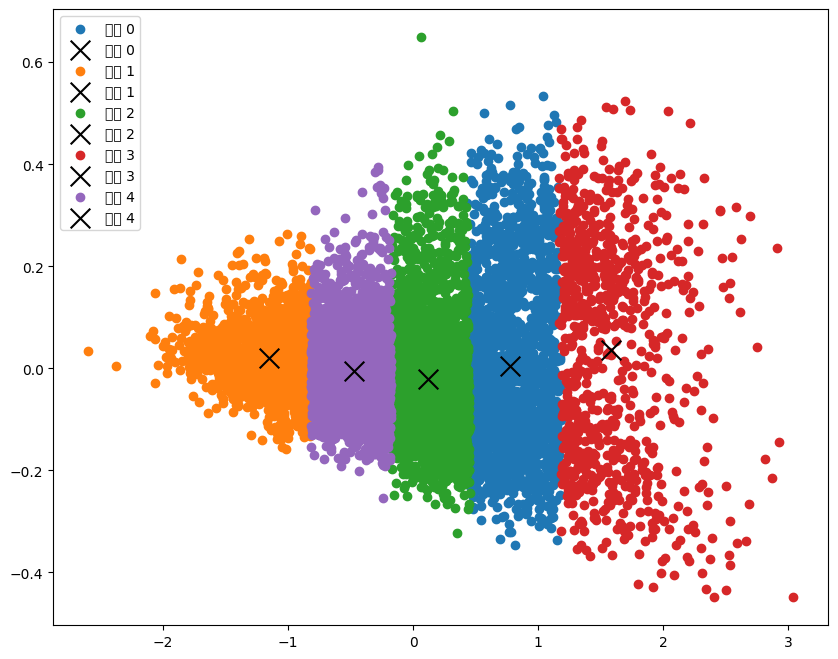

In [35]:
# 각 군집의 데이터와 중심을 시각화
plt.figure(figsize=(10, 8))
for i in range(k):
    plt.scatter(df[df['군집'] == i]['PCA1'], df[df['군집'] == i]['PCA2'], label='군집 '+str(i))
    plt.scatter(centroids_pca[i, 0], centroids_pca[i, 1], label='중심 '+str(i), marker='x', s=200, c='black')
plt.legend()
plt.show()

In [36]:
# 각 군집의 중심점에서 가장 가까운 100개의 데이터를 찾음
nearest_points = []
for i in range(k):
    # 해당 군집의 데이터를 선택
    cluster_points = df[df['군집'] == i][['PCA1', 'PCA2']].values

    # NearestNeighbors 모델 생성 및 학습
    nn = NearestNeighbors(n_neighbors=100)
    nn.fit(cluster_points)

    # 군집의 중심점에서 가장 가까운 데이터의 인덱스를 찾음
    distances, indices = nn.kneighbors([centroids_pca[i]])

    # 가장 가까운 데이터를 선택
    nearest_points.append(df.iloc[indices[0]])

In [37]:
# 가장 가까운 데이터를 합침
nearest_points_df = pd.concat(nearest_points)

In [39]:
import collections

with open('kmeans_output.txt', 'w', encoding='utf-8') as f:
    for i in range(k):
        f.write(f"군집 {i}:\n")

        for column in ['news_keyword', 'news_feature']:
            f.write(f"{column}에서 가장 많이 등장하는 단어 상위 5개:\n")

            # 해당 군집에서 해당 컬럼의 데이터를 모두 합칩니다.
            text = ','.join(nearest_points_df[nearest_points_df['군집'] == i][column])

            # 문자열을 단어로 분리합니다.
            words = text.split()

            # 가장 많이 등장하는 단어를 찾습니다.
            word_counts = collections.Counter(words)

            # 가장 빈번하게 등장하는 단어 상위 5개를 출력합니다.
            for word, count in word_counts.most_common(5):
                f.write(f"{word} : {count}\n")
            f.write("\n")

# ✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨

# 코사인 유사도
- 다른 유사도 사용해봤지만 코사인 유사도 계산이 가장 좋았습니다.

In [40]:
from sklearn.metrics.pairwise import cosine_similarity

# 'top5'와 'best_similarities' 컬럼을 초기화합니다.
df['top5'] = None
df['best_similarities'] = None

In [42]:
# vectors를 데이터프레임에 추가
df['vectors'] = list(vectors)

for idx, row in df.iterrows():
    # 해당 기사가 속한 군집의 다른 기사들을 선택합니다.
    cluster_articles = df[(df['군집'] == row['군집']) & (df.index != idx)]

    # 해당 기사와 군집 내 다른 기사들 사이의 코사인 유사도를 계산합니다.
    cosine_similarities = cosine_similarity(row['vectors'].reshape(1, -1), cluster_articles['vectors'].tolist())[0]

    # 코사인 유사도가 높은 순으로 기사를 정렬합니다.
    sorted_indices = cosine_similarities.argsort()[::-1]

    # 코사인 유사도가 가장 높은 5개의 기사의 'news_id'를 'top5' 컬럼에 저장합니다.
    df.at[idx, 'top5'] = cluster_articles.iloc[sorted_indices[:5]]['news_id'].tolist()

    # 코사인 유사도가 가장 높은 스코어를 'best_similarities' 컬럼에 저장합니다.
    df.at[idx, 'best_similarities'] = cosine_similarities[sorted_indices[0]]


# 최종 평균 유사도: 0.9881870490339438

In [43]:
# 'Best_similarities' 컬럼의 평균 유사도를 계산합니다.
average_similarity = df['best_similarities'].mean()

print("평균 유사도: ", average_similarity)

평균 유사도:  0.9881870490339438


In [44]:
df.head()

,news_id,news_date,news_keyword,news_feature,news_url,news_content,img_url,summery_content,NNP,news_feature_cleaned,news_keyword_cleaned,군집,PCA1,PCA2,top5,best_similarities,vectors
0,02100201.20240214165525001,2024-02-14,나혼산 규현 바퀜 주문폭주 소요 배송 순수 원조 진공 용기 신세계 CJ 메가 플랫폼...,바퀜 규현 메이커빌 나혼산 신세계백화점 메가플랫폼 온오프라인 신세계 밀폐용기 보관력...,http://news.moneytoday.co.kr/view/mtview.php?n...,2024-02-14머니투데이 이동오 기자 순수 국내기술로 개발한 원조 진공용기신세계...,https://www.bigkinds.or.kr/resources/images/02...,2024-02 14 머니투데이 동오 기자 순수 국내 기술 개발 원조 진공 용기 신세...,"[바퀜, 규현, 메이커빌, 나혼산, 신세계백화점, 신세계, 아마존, 미국, 규현, ...",바퀜 규현 메이커빌 나혼산 신세계백화점 메가플랫폼 온오프라인 신세계 밀폐용기 보관력...,나혼산 규현 바퀜 주문폭주 소요 배송 순수 원조 진공 용기 신세계 CJ 메가 플랫폼...,4,-0.618385,-0.091292,"[02100311.20210519171330001, 07100501.20220207...",0.986706,"[-0.01240931, -0.0626139, -0.16470762, -0.0226..."
1,02100201.20240214161101001,2024-02-14,렌즈스토어 뷰티 렌즈 편집숍 윙크 울산 대구 뷰티 콘택트렌즈 플랫폼 윙크컴퍼니 확대...,윙크컴퍼니 뷰티렌즈 대구 울산 큐레이션 정문기 중구 남구 렌즈스토어,http://news.moneytoday.co.kr/view/mtview.php?n...,2024-02-14머니투데이 조한송 기자 뷰티 콘택트렌즈 플랫폼 윙크컴퍼니가 고객 ...,https://www.bigkinds.or.kr/resources/images/02...,2024-02 14 머니투데이 기자 뷰티 콘택트렌즈 플랫폼 윙크 컴퍼니 고객 경험 ...,"[대구, 울산, 큐레이션, 중구, 남구, 울산, 대구, 울산광역시, 대구광역시, 뷰...",윙크컴퍼니 뷰티렌즈 대구 울산 큐레이션 정문기 중구 남구 렌즈스토어,렌즈스토어 뷰티 렌즈 편집숍 윙크 울산 대구 뷰티 콘택트렌즈 플랫폼 윙크컴퍼니 확대...,4,-0.284783,0.113620,"[01500601.20231203184818001, 02100311.20231010...",0.959459,"[0.014388972, 0.06500725, -0.20224823, 0.03685..."
2,01500601.20240214160335001,2024-02-14,대표이사 대구불로탁주 최종국 이사 생물 도전장 지역 막걸리 글로벌 막걸리 생물 막걸...,대구 대구불로탁주 불로막걸리 품평회 생막걸리 양조장 대한민국 한국막걸리협회 동구 생...,https://www.imaeil.com/page/view/2024021314385...,2024-02-14막걸리는 살아있는 생물입니다. 지역 전통 막걸리의 맛을 전국을 넘...,https://www.bigkinds.or.kr/resources/images/01...,2024-02 14 막걸리 생물 지역 전통 막걸리 전국 세계 시장 계획 50 이상 ...,"[대구, 대구부, 대한민국, 한국, 일본, 대구부, 대구, 불로동, 대구, 안재모,...",대구 대구불로탁주 불로막걸리 품평회 생막걸리 양조장 대한민국 한국막걸리협회 동구 생...,대표이사 대구불로탁주 최종국 이사 생물 도전장 지역 막걸리 글로벌 막걸리 생물 막걸...,2,-0.106130,0.035460,"[01100401.20230727030456001, 02100501.20220718...",0.988909,"[-0.0012919904, -0.060332727, -0.3052283, 0.01..."
3,07100501.20240214144618001,2024-02-14,신세계 강남점 엄브로 단독 주년 선봬 신세계백화점 영국 스포츠 엄브로 주년 업계 단...,엄브로 강남점 영국 혼네 신세계백화점 주년 굿즈 엄브 일상복 선현우 신세계 선착순 ...,http://www.etnews.com/20240214000260,2024-02-14신세계백화점은 영국 스포츠 브랜드 엄브로 론칭 100주년을 맞아 ...,https://www.bigkinds.or.kr/resources/images/07...,2024-02 14 신세계 백화점 영국 스포츠 브랜드 엄브로 론칭 100 주년 업계...,"[엄브로, 영국, 혼네, 신세계백화점, 현우, 신세계, 신세계, 엄브로, 신세계백화...",엄브로 강남점 영국 혼네 신세계백화점 주년 굿즈 엄브 일상복 선현우 신세계 선착순 ...,신세계 강남점 엄브로 단독 주년 선봬 신세계백화점 영국 스포츠 엄브로 주년 업계 단...,0,1.054255,-0.039657,"[02100501.20240214103102002, 02100851.20240214...",0.996059,"[-0.0258221, -0.123161815, -0.4405544, 0.00962..."
4,02100501.20240214103102002,2024-02-14,신세계 강남점 엄브로 단독 주년 신세계백화점 영국 스포츠 엄브로 주년 업계 단독 1...,영국 엄브로 엄브 신세계백화점 주년 강남점 신세계 축구팀 일상복 오랫동안 선현우 블...,http://www.fnnews.com/news/202402141025245334,2024-02-14파이낸셜뉴스 신세계백화점은 영국 스포츠 브랜드 엄브로의 론칭 10...,https://www.bigkinds.or.kr/resources/images/02...,2024-02 14 파이낸셜뉴스 신세계 백화점 영국 스포츠 브랜드 엄브로 론칭 10...,"[영국, 엄브로, 엄브, 신세계백화점, 신세계, 현우, 맨체스터, 신세계, 엄브로,...",영국 엄브로 엄브 신세계백화점 주년 강남점 신세계 축구팀 일상복 오랫동안 선현우 블...,신세계 강남점 엄브로 단독 주년 신세계백화점 영국 스포츠 엄브로 주년 업계 단독 1...,0,0.598197,-0.047057,"[07100501.20240214144618001, 01100401.20240111...",0.996059,"[-0.021024222, -0.1408611, -0.38499716, 0.0172..."


# 검증
- 지금 1000이라고 입력되어 있는 숫자를 바꾸면 해당 행과 관련된 news_url을 출력하게 됩니다.

In [57]:
def print_top5_news_urls(df, idx):
    # 주어진 인덱스의 행에서 top5 news_id를 가져옵니다.
    top5_news_ids = df.iloc[idx]['top5']

    # 해당 news_id를 가진 행들을 선택합니다.
    selected_rows = df[df['news_id'].isin(top5_news_ids)]
    
    # 기준이 되는 행의 'news_feature_cleand'를 출력합니다.
    print("기준 뉴스: ", df.iloc[idx]['news_feature_cleaned'])
    
    # 선택된 행들의 news_url을 출력합니다.
    print(selected_rows['news_url'])

# 예제: 3번째 행의 top5 news_url을 출력합니다.
print_top5_news_urls(df, 159)


기준 뉴스:  하이볼 레비테이트 진공저온 아시아 40회 박상원 인공지능 전산화 스마트팩토리지원사업 향신료 원재료 로마 시애틀 아시아나항공사 달서구 3사 고품질 20가지 제주 전통주 스타트업 극대화 세대들 이지블렌드 대구 탄산수 50만 브랜드명 취항지 액상스틱
6588        http://www.fnnews.com/news/202207291531345560
6904    http://news.mk.co.kr/newsRead.php?no=552214&ye...
8053    http://biz.heraldcorp.com/view.php?ud=20211214...
9147    https://www.hankyung.com/economy/article/20210...
9398    https://www.inews365.com/news/article.html?no=...
Name: news_url, dtype: object
